# Automated Machine Learning
**BikeShare Demand Forecasting**

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Evaluate](#Evaluate)

## Introduction
This notebook demonstrates demand forecasting for a bike-sharing service using AutoML.

AutoML highlights here include built-in holiday featurization, accessing engineered feature names, and working with the `forecast` function. Please also look at the additional forecasting notebooks, which document lagging, rolling windows, forecast quantiles, other ways to use the forecast function, and forecaster deployment.

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

Notebook synopsis:
1. Creating an Experiment in an existing Workspace
2. Configuration and local run of AutoML for a time-series model with lag and holiday features 
3. Viewing the engineered names for featurized data and featurization summary for all raw features
4. Evaluating the fitted model using a rolling test 

In [1]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]'

In [2]:
import datetime
print("Current date and time: " , datetime.datetime.now())

Current date and time:  2019-08-27 12:42:23.383566


## Setup


In [3]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [4]:
#Install librairies
#!pip install azureml-sdk
#!pip install --upgrade azureml-sdk
#!pip install --upgrade azureml-sdk[automl,notebooks,explain]

In [5]:
#Version
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.53


In [6]:
#Workspace
import os
subscription_id = os.environ.get("SUBSCRIPTION_ID", "A COMPLETER")
resource_group = os.environ.get("RESOURCE_GROUP", "azuremlserviceresourcegroup")
workspace_name = os.environ.get("WORKSPACE_NAME", "azuremlservice")


from azureml.core import Workspace
try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("OK")
except:
   print("Error: Workspace not found")

OK


In [28]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-bikeshareforecasting'
# project folder
project_folder = './sample_projects/automl-local-bikeshareforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.53
Workspace,azuremlservice
Resource Group,azuremlserviceresourcegroup
Location,westeurope
Project Directory,./sample_projects/automl-local-bikeshareforecasting
Run History Name,automl-bikeshareforecasting


## Data
Read bike share demand data from file, and preview data.

In [8]:
data = pd.read_csv('bike-no.csv', parse_dates=['date'])
data.head(10)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,6,2,0.34,0.36,0.81,0.16,331,654,985
1,2,2011-01-02,1,0,1,0,2,0.36,0.35,0.70,0.25,131,670,801
2,3,2011-01-03,1,0,1,1,1,0.20,0.19,0.44,0.25,120,1229,1349
3,4,2011-01-04,1,0,1,2,1,0.20,0.21,0.59,0.16,108,1454,1562
4,5,2011-01-05,1,0,1,3,1,0.23,0.23,0.44,0.19,82,1518,1600
5,6,2011-01-06,1,0,1,4,1,0.20,0.23,0.52,0.09,88,1518,1606
6,7,2011-01-07,1,0,1,5,2,0.20,0.21,0.50,0.17,148,1362,1510
7,8,2011-01-08,1,0,1,6,2,0.17,0.16,0.54,0.27,68,891,959
8,9,2011-01-09,1,0,1,0,1,0.14,0.12,0.43,0.36,54,768,822
9,10,2011-01-10,1,0,1,1,1,0.15,0.15,0.48,0.22,41,1280,1321


Let's set up what we know about the dataset. 

**Target column** is what we want to forecast.

**Time column** is the time axis along which to predict.

**Grain** is another word for an individual time series in your dataset. Grains are identified by values of the columns listed `grain_column_names`, for example "store" and "item" if your data has multiple time series of sales, one series for each combination of store and item sold.

This dataset has only one time series. Please see the [orange juice notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales) for an example of a multi-time series dataset.

In [9]:
target_column_name = 'cnt'
time_column_name = 'date'
grain_column_names = []

## Split the data

The first split we make is into train and test sets. Note we are splitting on time.

In [10]:
train = data[data[time_column_name] < '2012-09-01']
test = data[data[time_column_name] >= '2012-09-01']

X_train = train.copy()
y_train = X_train.pop(target_column_name).values

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(609, 13)
(609,)
(122, 13)
(122,)


### Setting forecaster maximum horizon 

The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 14 periods (i.e. 14 days). Notice that this is much shorter than the number of days in the test set; we will need to use a rolling test to evaluate the performance on the whole test set. For more discussion of forecast horizons and guiding principles for setting them, please see the [energy demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand).  

In [11]:
max_horizon = 14

## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits.|
|**country_or_region**|The country/region used to generate holiday features. These should be ISO 3166 two-letter country/region codes (i.e. 'US', 'GB').|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

In [13]:
automl_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    # knowing the country/region allows Automated ML to bring in holidays
    'country_or_region': 'US',
    'target_lags': 1,
    # these columns are a breakdown of the total and therefore a leak
    'drop_column_names': ['casual', 'registered']
}

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             iterations=20,
                             iteration_timeout_minutes=10,
                             X=X_train,
                             y=y_train,
                             n_cross_validations=3,  
                             enable_voting_ensemble=False,
                             enable_stack_ensemble=False,
                             path=project_folder,
                             verbosity=logging.INFO,
                            **automl_settings)

We will now run the experiment, starting with 10 iterations of model search. The experiment can be continued for more iterations if more accurate results are required. You will see the currently running iterations printing to the console.

In [14]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_25b008bc-0e49-406b-94ce-bf6b4523af62
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:17       0.1041  

Displaying the run objects gives you links to the visual tools in the Azure Portal. Go try them!

In [15]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-bikeshareforecasting,AutoML_25b008bc-0e49-406b-94ce-bf6b4523af62,automl,Completed,Link to Azure Portal,Link to Documentation


### Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [16]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None)),
 ('StandardScalerWrapper',
  <automl.client.core.common.model_wrappers.StandardScalerWrapper at 0x13a16fa4fd0>),
 ('LightGBMRegressor',
  LightGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
           importance_type='split', learning_rate=0.1052678947368421,
           max_bin=7, max_depth=7, min_child_samples=17,
           min_child_weight=0.001, min_split_gain=0.7368421052631579,
           n_estimators=50, n_jobs=1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0, reg_lambda=1.5, silent=True,
           subsample=0.65, subsample_for_bin=200000, subsample_freq=1,
           verbose=-1))]

### View the engineered names for featurized data

You can accees the engineered feature names generated in time-series featurization. Note that a number of named holiday periods are represented. We recommend that you have at least one year of data when using this feature to ensure that all yearly holidays are captured in the training featurization.

In [17]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['atemp',
 'atemp_WASNULL',
 'horizon_origin',
 'hum',
 'hum_WASNULL',
 'instant',
 'instant_WASNULL',
 'mnth',
 'mnth_WASNULL',
 'season',
 'season_WASNULL',
 'temp',
 'temp_WASNULL',
 'weathersit',
 'weathersit_WASNULL',
 'weekday',
 'weekday_WASNULL',
 'windspeed',
 'windspeed_WASNULL',
 'yr',
 'yr_WASNULL',
 '_automl_target_col_lag1D',
 'year',
 'year_iso',
 'half',
 'quarter',
 'month',
 'day',
 'wday',
 'qday',
 'week',
 '_IsPaidTimeOff',
 '_Holiday_1 day after Christmas Day',
 '_Holiday_1 day after Columbus Day',
 '_Holiday_1 day after Independence Day',
 '_Holiday_1 day after Labor Day',
 '_Holiday_1 day after Martin Luther King, Jr. Day',
 '_Holiday_1 day after Memorial Day',
 "_Holiday_1 day after New Year's Day",
 '_Holiday_1 day after Thanksgiving',
 '_Holiday_1 day after Veterans Day',
 "_Holiday_1 day after Washington's Birthday",
 '_Holiday_1 day before Christmas Day',
 '_Holiday_1 day before Columbus Day',
 '_Holiday_1 day before Independence Day',
 '_Holiday_1 day befo

### View the featurization summary

You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

- Raw feature name
- Number of engineered features formed out of this raw feature
- Type detected
- If feature was dropped
- List of feature transformations for the raw feature

In [18]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Tranformations
0,atemp,Numeric,No,2,"[MeanImputer, ImputationMarker]"
1,date,DateTime,No,105,"[MaxHorizonFeaturizer, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, DateTime-OneHotEncoder, ...]"
2,hum,Numeric,No,2,"[MeanImputer, ImputationMarker]"
3,instant,Numeric,No,2,"[MeanImputer, ImputationMarker]"
4,mnth,Numeric,No,2,"[MeanImputer, ImputationMarker]"
5,season,Numeric,No,2,"[MeanImputer, ImputationMarker]"
6,temp,Numeric,No,2,"[MeanImputer, ImputationMarker]"
7,weathersit,Numeric,No,2,"[MeanImputer, ImputationMarker]"
8,weekday,Numeric,No,2,"[MeanImputer, ImputationMarker]"
9,windspeed,Numeric,No,2,"[MeanImputer, ImputationMarker]"


## Evaluate

We now use the best fitted model from the AutoML Run to make forecasts for the test set.  

We always score on the original dataset whose schema matches the training set schema.

In [19]:
X_test.head()

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered
609,610,2012-09-01,3,1,9,6,2,0.75,0.70,0.64,0.11,2352,3788
610,611,2012-09-02,3,1,9,0,2,0.70,0.65,0.81,0.06,2613,3197
611,612,2012-09-03,3,1,9,1,1,0.71,0.66,0.79,0.15,1965,4069
612,613,2012-09-04,3,1,9,2,1,0.73,0.69,0.76,0.24,867,5997
613,614,2012-09-05,3,1,9,3,1,0.74,0.71,0.74,0.19,832,6280


We now define some functions for aligning output to input and for producing rolling forecasts over the full test set. As previously stated, the forecast horizon of 14 days is shorter than the length of the test set - which is about 120 days. To get predictions over the full test set, we iterate over the test set, making forecasts 14 days at a time and combining the results. We also make sure that each 14-day forecast uses up-to-date actuals - the current context - to construct lag features. 

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [20]:
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted,
                            horizon_colname: X_trans[horizon_colname]})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

def do_rolling_forecast(fitted_model, X_test, y_test, max_horizon, freq='D'):
    """
    Produce forecasts on a rolling origin over the given test set.
    
    Each iteration makes a forecast for the next 'max_horizon' periods 
    with respect to the current origin, then advances the origin by the horizon time duration. 
    The prediction context for each forecast is set so that the forecaster uses 
    the actual target values prior to the current origin time for constructing lag features.
    
    This function returns a concatenated DataFrame of rolling forecasts.
     """
    df_list = []
    origin_time = X_test[time_column_name].min()
    while origin_time <= X_test[time_column_name].max():
        # Set the horizon time - end date of the forecast
        horizon_time = origin_time + max_horizon * to_offset(freq)
        
        # Extract test data from an expanding window up-to the horizon 
        expand_wind = (X_test[time_column_name] < horizon_time)
        X_test_expand = X_test[expand_wind]
        y_query_expand = np.zeros(len(X_test_expand)).astype(np.float)
        y_query_expand.fill(np.NaN)
        
        if origin_time != X_test[time_column_name].min():
            # Set the context by including actuals up-to the origin time
            test_context_expand_wind = (X_test[time_column_name] < origin_time)
            context_expand_wind = (X_test_expand[time_column_name] < origin_time)
            y_query_expand[context_expand_wind] = y_test[test_context_expand_wind]
        
        # Make a forecast out to the maximum horizon
        y_fcst, X_trans = fitted_model.forecast(X_test_expand, y_query_expand)
        
        # Align forecast with test set for dates within the current rolling window 
        trans_tindex = X_trans.index.get_level_values(time_column_name)
        trans_roll_wind = (trans_tindex >= origin_time) & (trans_tindex < horizon_time)
        test_roll_wind = expand_wind & (X_test[time_column_name] >= origin_time)
        df_list.append(align_outputs(y_fcst[trans_roll_wind], X_trans[trans_roll_wind],
                                     X_test[test_roll_wind], y_test[test_roll_wind]))
        
        # Advance the origin time
        origin_time = horizon_time
    
    return pd.concat(df_list, ignore_index=True)

In [21]:
df_all = do_rolling_forecast(fitted_model, X_test, y_test, max_horizon)
df_all

,date,_automl_dummy_grain_col,origin,predicted,horizon_origin,instant,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2012-09-01,_automl_dummy_grain_col,2012-08-31,7225.13,1,610,3,1,9,6,2,0.75,0.70,0.64,0.11,2352,3788,6140
1,2012-09-02,_automl_dummy_grain_col,2012-08-31,5028.07,2,611,3,1,9,0,2,0.70,0.65,0.81,0.06,2613,3197,5810
2,2012-09-03,_automl_dummy_grain_col,2012-08-31,5862.60,3,612,3,1,9,1,1,0.71,0.66,0.79,0.15,1965,4069,6034
3,2012-09-04,_automl_dummy_grain_col,2012-08-31,6092.59,4,613,3,1,9,2,1,0.73,0.69,0.76,0.24,867,5997,6864
4,2012-09-05,_automl_dummy_grain_col,2012-08-31,6490.40,5,614,3,1,9,3,1,0.74,0.71,0.74,0.19,832,6280,7112
5,2012-09-06,_automl_dummy_grain_col,2012-08-31,6153.64,6,615,3,1,9,4,2,0.70,0.66,0.81,0.14,611,5592,6203
6,2012-09-07,_automl_dummy_grain_col,2012-08-31,6734.70,7,616,3,1,9,5,1,0.70,0.66,0.74,0.17,1045,6459,7504
7,2012-09-08,_automl_dummy_grain_col,2012-08-31,4958.77,8,617,3,1,9,6,2,0.66,0.61,0.80,0.28,1557,4419,5976
8,2012-09-09,_automl_dummy_grain_col,2012-08-31,6747.51,9,618,3,1,9,0,1,0.61,0.58,0.55,0.22,2570,5657,8227
9,2012-09-10,_automl_dummy_grain_col,2012-08-31,7022.07,10,619,3,1,9,1,1,0.58,0.57,0.50,0.26,1118,6407,7525


We now calculate some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [24]:
def APE(actual, pred):
    """
    Calculate absolute percentage error.
    Returns a vector of APE values with same length as actual/pred.
    """
    return 100*np.abs((actual - pred)/actual)

def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    return np.mean(APE(actual_safe, pred_safe))

Simple forecasting model
[Test Data] 
Root Mean squared error: 1153.47
mean_absolute_error score: 936.37
MAPE: 189.92


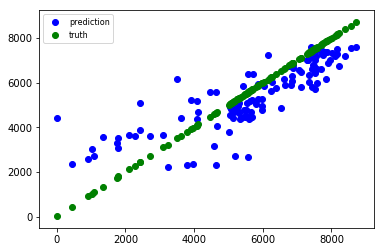

In [25]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

The MAPE seems high; it is being skewed by an actual with a small absolute value. For a more informative evaluation, we can calculate the metrics by forecast horizon:

In [26]:
df_all.groupby('horizon_origin').apply(
    lambda df: pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted']),
                          'RMSE': np.sqrt(mean_squared_error(df[target_column_name], df['predicted'])),
                          'MAE': mean_absolute_error(df[target_column_name], df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,33.96,1611.55,1513.23
2,28.97,1043.71,938.09
3,2235.98,1580.21,841.96
4,53.71,1240.78,1130.71
5,59.32,1053.64,910.85
6,18.14,986.22,805.13
7,12.51,771.17,730.71
8,32.61,1334.25,1122.47
9,33.10,1517.39,1336.41


It's also interesting to see the distributions of APE (absolute percentage error) by horizon. On a log scale, the outlying APE in the horizon-3 group is clear.

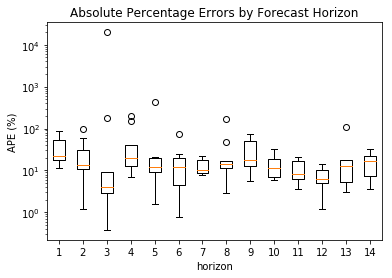

In [27]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, max_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()

> Fin